# Open Max Recognition for MoViNet (54 classes)

In [1]:
import time
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
# import transforms as T
from movinets import MoViNet
from movinets.config import _C

from torchvision.datasets.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.folder import find_classes, make_dataset

import os
import glob
import json

import numpy as np
import cv2
import mediapy as media
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

## Video Processing

In [2]:
def load_video(file_path, image_size=(224, 224), original_fps=30, new_fps=5, start_time=None, end_time=None, gray=False):
    """Loads a video file into a TF tensor."""
    cap = cv2.VideoCapture(file_path)
    
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fc = 0
    ret = True

    if start_time and end_time:
        start_frame = original_fps * start_time
        end_frame = original_fps * end_time
    else:
        start_frame = 0
        end_frame = frameCount
    
    fps_factor = original_fps / new_fps
    now_frame = 0
    if gray:
        buf = np.zeros((int((end_frame - start_frame) / fps_factor), image_size[1], image_size[0]), np.dtype('uint8'))
    else:
        buf = np.zeros((int((end_frame - start_frame) / fps_factor), image_size[1], image_size[0], 3), np.dtype('uint8'))
    
    while (fc < frameCount  and ret):
        ret, tmp = cap.read()
        now_frame += 1
        if start_frame > now_frame:
            continue
        if end_frame < now_frame:
            break
        if now_frame % fps_factor == 0:
            tmp = cv2.resize(tmp, dsize=image_size)
            if gray:
                buf[fc] = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
            else:
                buf[fc] = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
            fc += 1
    cap.release()
    
    return buf

In [3]:
def preprocess_video(path, image_size=(224,224), frame_num=50, dtype=np.float32):
    # thwc
    video = load_video(path, image_size=image_size)
    
    # set t=frame_num
    t,h,w,c = video.shape
    if t < frame_num:
        fill_n = frame_num - t
        video = np.concatenate([video, torch.zeros((fill_n, h, w, c), dtype=torch.uint8)], axis=0)
    elif t > frame_num:
        video = video[:frame_num]
    
    # cthw
    video = np.transpose(video, (3,0,1,2))
    
    # ncthw
    video = np.expand_dims(video, axis=0)
    
    video = video.astype(dtype)
    if dtype == np.float32:
        video /= 255
    
    return video

In [4]:
## load class names

with open("54classes.json", 'r') as f:
    classes = json.load(f)
classes_dict = {}
for key, value in classes.items():
    classes_dict[value] = key
    
print(classes_dict)

{0: 'adjusting_glasses', 1: 'blowing_nose', 2: 'brushing_hair', 3: 'brushing_teeth', 4: 'calculating', 5: 'calligraphy', 6: 'chewing_gum', 7: 'clapping', 8: 'coughing', 9: 'counting_money', 10: 'cracking_knuckles', 11: 'cracking_neck', 12: 'doing_sudoku', 13: 'drawing', 14: 'drinking_shots', 15: 'eating_burger', 16: 'eating_cake', 17: 'eating_carrots', 18: 'eating_chips', 19: 'eating_doughnuts', 20: 'eating_hotdog', 21: 'eating_ice_cream', 22: 'eating_nachos', 23: 'eating_spaghetti', 24: 'eating_watermelon', 25: 'fixing_hair', 26: 'laughing', 27: 'massaging_back', 28: 'massaging_feet', 29: 'massaging_legs', 30: 'massaging_neck', 31: "massaging_person's_head", 32: 'news_anchoring', 33: 'opening_bottle_(not_wine)', 34: 'opening_door', 35: 'raising_eyebrows', 36: 'reading_book', 37: 'reading_newspaper', 38: 'recording_music', 39: 'rolling_eyes', 40: 'sipping_cup', 41: 'sneezing', 42: 'stretching_arm', 43: 'taking_photo', 44: 'talking_on_cell_phone', 45: 'texting', 46: 'tying_necktie', 47:

## Model Loading and Visualization

In [5]:
model = MoViNet(_C.MODEL.MoViNetA2, causal = False, pretrained = False)
model.classifier[3] = torch.nn.Conv3d(2048, 54, (1,1,1)) # 54 classes
model.load_state_dict(torch.load('movinet_iter5_a2.pth', map_location=torch.device('cpu')))
model.eval()
model.cuda()

MoViNet(
  (conv1): ConvBlock3D(
    (conv_1): Conv3DBNActivation(
      (conv3d): Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
      (norm): BatchNorm3d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act): Swish()
    )
  )
  (blocks): Sequential(
    (b0_l0): BasicBneck(
      (expand): ConvBlock3D(
        (conv_1): Conv3DBNActivation(
          (conv3d): Conv3d(16, 40, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm): BatchNorm3d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act): Swish()
        )
      )
      (deep): ConvBlock3D(
        (conv_1): Conv3DBNActivation(
          (conv3d): Conv3d(40, 40, kernel_size=(1, 5, 5), stride=(1, 2, 2), padding=(0, 2, 2), groups=40, bias=False)
          (norm): BatchNorm3d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act): Swish()
        )
      )
      (se): SqueezeExcitation(
      

In [6]:
# Visualize

video_names = glob.glob("/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/val/ados2/그림그리기/그림그리기_김민태.mp4")

# load video
test_path = video_names[0]
video = load_video(test_path, image_size=(224,224))

# Visualize video
media.show_video(video, fps=5)

## Inference

In [7]:
def computeLogit(input_data):
    with torch.no_grad():
        pred = model(input_data)
        output = F.softmax(pred, dim=1)
        return output 

In [8]:
# Inference

# Take 20 videos from each class
# class_names = glob.glob("/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/val/sample/**")
class_names = glob.glob("/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/train/normal/**")

num_videos = 300
video_names = [glob.glob(class_path + '/**')[:num_videos] for class_path in class_names]
video_dict = {videos[0].split('/')[-2]: videos for videos in video_names}
path = video_dict['drawing'][0]

input_data = preprocess_video(path)
input_data = torch.from_numpy(input_data).cuda()
output = computeLogit(input_data)

output

tensor([[2.6112e-04, 4.1467e-07, 7.5053e-07, 4.2073e-07, 3.9741e-06, 1.1497e-05,
         4.8290e-07, 1.3393e-07, 5.8631e-06, 5.9845e-06, 8.3194e-06, 7.2655e-06,
         1.5027e-05, 9.9956e-01, 6.2737e-08, 2.7687e-06, 4.7036e-07, 2.3170e-07,
         2.5620e-07, 1.8018e-07, 1.1217e-08, 7.8269e-07, 6.6889e-07, 7.2834e-06,
         5.7778e-09, 1.7127e-05, 3.6553e-07, 1.4741e-06, 2.2410e-07, 5.3286e-08,
         5.3242e-06, 2.0942e-05, 1.7275e-07, 1.9766e-07, 1.4107e-06, 1.5797e-06,
         2.5026e-07, 9.9018e-07, 4.4624e-06, 2.6606e-06, 1.8958e-07, 1.7581e-05,
         6.2123e-08, 3.5837e-07, 1.0913e-07, 5.9539e-07, 1.4057e-05, 3.5339e-08,
         5.1010e-07, 3.7056e-07, 6.7502e-08, 5.4924e-08, 1.4227e-05, 1.1130e-06]],
       device='cuda:0')

## Meta Recognition

- Meta Recognition
    - mean: Mean of logits by classes (54, 1, 54)
    - output_matrix: Outputs from the model (54, 300, 54)
    - distance: Distances between outputs and mean (54, 300, 54)

In [9]:
# Sample 20 videos from each class for open set learning
# Create output_matrix and mean

mean = torch.zeros(54, 1, 54)
output_matrix = torch.zeros(54, num_videos, 54)

c = 0
for class_name in sorted(list(video_dict.keys())): # 54
    s = torch.zeros(1, 54).cuda()
    v = 0
    for path in tqdm(video_dict[class_name], desc=class_name): # 300
        time.sleep(0.01)
        input_data = preprocess_video(path)
        input_data = torch.from_numpy(input_data).cuda()
        output = computeLogit(input_data)
        output_matrix[c][v] = output
        s = s.add(output)
        v += 1
    mean[c] = torch.mul(s, 1/num_videos)
    c += 1

print(torch.argmax(mean, dim=0)) # mean of 20 logits seems working fine

distance = torch.zeros(54, 1, num_videos)
for i in range(54):
    distance[i], indices = torch.sort(torch.norm(output_matrix[i] - mean[i], dim=1), descending=True)

yawning: 100%|██████████| 300/300 [00:27<00:00, 11.10it/s]

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]])


- Weibull Distribution
    - sample_distance: Top k distances out of distance (54, 1, k)
    - Top k dist = Distances of the most irrelevant k samples

In [10]:
k = 100
sampled_distance = distance[:, :, 0:k]
sampled_distance[10]

tensor([[1.2789, 1.2786, 1.2779, 1.2703, 1.2684, 1.2496, 1.2158, 1.1975, 1.1769,
         1.1718, 1.1690, 1.1619, 1.1123, 1.0910, 1.0857, 1.0838, 1.0739, 1.0644,
         1.0644, 1.0502, 1.0222, 1.0065, 1.0047, 1.0030, 0.9403, 0.9373, 0.9348,
         0.9284, 0.9263, 0.8963, 0.8916, 0.8471, 0.8213, 0.8115, 0.7746, 0.7709,
         0.7335, 0.7065, 0.6061, 0.5452, 0.4851, 0.4818, 0.4808, 0.4507, 0.4398,
         0.4318, 0.3320, 0.3298, 0.3246, 0.2879, 0.2608, 0.2582, 0.2544, 0.2432,
         0.2420, 0.2420, 0.2197, 0.2130, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717,
         0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717,
         0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717,
         0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717, 0.1717,
         0.1717, 0.1717, 0.1716, 0.1716, 0.1716, 0.1716, 0.1716, 0.1716, 0.1716,
         0.1716]])

In [11]:
def fit_weibull(x, iters=100, eps=1e-6, use_cuda=True):
    k = 1.0
    k_t_1 = k
    ln_x = torch.log(x)

    for i in range(iters):
        # Partial derivative df/dk
        x_k = x ** k
        x_k_ln_x = x_k * ln_x
        ff = torch.sum(x_k_ln_x)
        fg = torch.sum(x_k)
        f1 = torch.mean(ln_x)
        f = ff/fg - f1 - (1.0 / k)

        ff_prime = torch.sum(x_k_ln_x * ln_x)
        fg_prime = ff
        f_prime = (ff_prime / fg - (ff / fg * fg_prime / fg)) + (1. / (k * k))

        # Newton-Raphson method k = k - f(k;x)/f'(k;x)
        k -= f / f_prime
        # print('f=% 7.5f, dk=% 7.5f, k=% 7.5f' % (f.data[0], k.grad.data[0], k.data[0]))
        if np.isnan(f):
            return np.nan, np.nan
        if abs(k - k_t_1) < eps:
            break

        k_t_1 = k

    # Lambda (scale) can be calculated directly
    lam = torch.mean(x ** k) ** (1.0 / k)

    return torch.Tensor([[k, lam]])  # Shape (SC), Scale (FE)

In [12]:
weibull_param = torch.zeros(54, 2)
fit_weibull(sampled_distance[0][0])

for i in range(54):
    sample = sampled_distance[i][0]
    weibull_param[i] = torch.Tensor(fit_weibull(sample, iters=100))

In [13]:
def compute_weibull_likelihood(param, dist):
    k, lam = param
    weibull_likelihood = k / lam * (dist/lam)**(k-1) * torch.exp(-(dist/lam)**k)
    return weibull_likelihood

def compute_weibull_probability(param, dist):
    k, lam = param
    weibull_probability = torch.ones(1) - torch.exp(-(dist/lam)**k)
    return weibull_probability.cuda()

In [35]:
def openmax(path, model):
    input_data = preprocess_video(path)
    input_data = torch.from_numpy(input_data).cuda()

    with torch.no_grad():
        pred = model(input_data)
        output = F.softmax(pred, dim=1)
        _, result = torch.max(output, dim=1)
        print(torch.argmax(output), classes_dict[torch.argmax(output).cpu().item()])
        print(output[0])
    
    dist = torch.zeros(54)
    for i in range(54):
        dist[i] = torch.norm(output.cpu()[0] - mean[i][0])
    
    weibull_probability = torch.Tensor(54)
    for i in range(54):
        weibull_probability[i] = compute_weibull_probability(weibull_param[i], dist[i])
    
    weibull_probability = weibull_probability.cuda()
    new_output = torch.cat([torch.sum(output * weibull_probability).view(1), output[0] * (1 - weibull_probability)])
    
    value, indices = torch.topk(new_test_output, k=5, dim=0)
    result = ['unknown' if index == 0 else classes_dict[int(index) - 1] for index in indices]
    
    plt.figure(figsize=(15, 4))
    plt.bar(sorted(["Unknown"] + list(video_dict.keys())), torch.softmax(new_output.cpu(), dim=0))
    plt.xticks(rotation=90)
    plt.show()

## Test - Ados Drawing

In [36]:
test_path = '/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/val/ados2/그림그리기/그림그리기_문형민.mp4'
test_video = load_video(test_path, image_size=(224,224))

media.show_video(test_video, fps=5)

tensor(38, device='cuda:0') recording_music
tensor([2.0386e-03, 1.2923e-04, 9.9884e-04, 3.1795e-04, 1.6429e-03, 6.0288e-04,
        1.8951e-03, 9.9927e-04, 3.8172e-02, 4.7173e-04, 2.2728e-03, 7.4645e-03,
        7.4249e-04, 8.2545e-03, 1.8243e-04, 6.8378e-04, 4.1518e-03, 1.5520e-04,
        1.5135e-04, 5.8711e-04, 5.4330e-04, 5.8267e-04, 2.8410e-04, 7.3999e-04,
        4.1285e-04, 1.6697e-02, 6.4883e-02, 8.9200e-03, 2.9577e-03, 3.1634e-04,
        7.2243e-02, 4.9559e-02, 1.8344e-02, 4.1180e-04, 2.2379e-04, 1.3751e-01,
        1.7617e-02, 7.1137e-03, 4.0517e-01, 6.8367e-02, 5.1386e-05, 2.1855e-03,
        4.2224e-03, 3.4709e-03, 1.2955e-02, 5.5009e-03, 3.5398e-04, 3.4908e-05,
        1.1670e-04, 2.8419e-04, 2.3215e-04, 1.3144e-03, 1.0367e-02, 1.4099e-02],
       device='cuda:0')


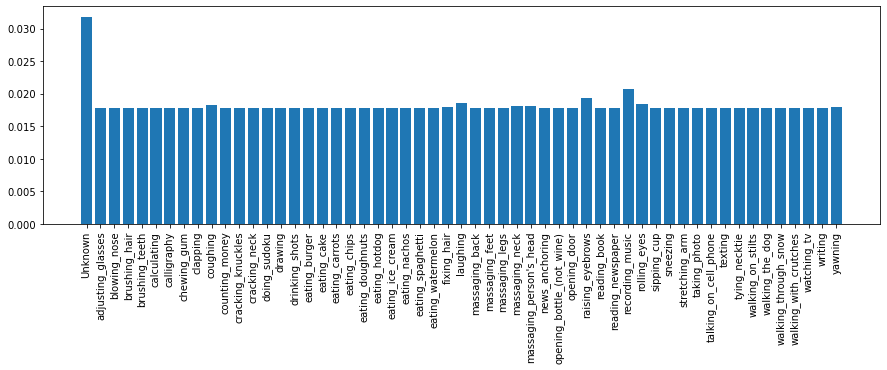

In [37]:
openmax(test_path, model)

## Test - Never Seen

In [38]:
# Data never seen

never_seen_path = "./Shooting_MJ.mp4"
never_seen_video = load_video(never_seen_path, image_size=(224,224))

# Visualize video
media.show_video(never_seen_video, fps=5)

tensor(19, device='cuda:0') eating_doughnuts
tensor([0.0078, 0.0068, 0.0135, 0.0028, 0.0036, 0.0018, 0.0170, 0.1136, 0.0138,
        0.0476, 0.0117, 0.0033, 0.0064, 0.0072, 0.0182, 0.0267, 0.0072, 0.0065,
        0.0031, 0.1886, 0.0121, 0.0060, 0.0048, 0.0017, 0.0085, 0.0131, 0.0151,
        0.0571, 0.0078, 0.0052, 0.0060, 0.0340, 0.0242, 0.0067, 0.0040, 0.0081,
        0.0042, 0.0046, 0.0232, 0.0042, 0.0092, 0.0060, 0.0415, 0.0486, 0.0035,
        0.0157, 0.0092, 0.0181, 0.0302, 0.0193, 0.0131, 0.0045, 0.0040, 0.0192],
       device='cuda:0')


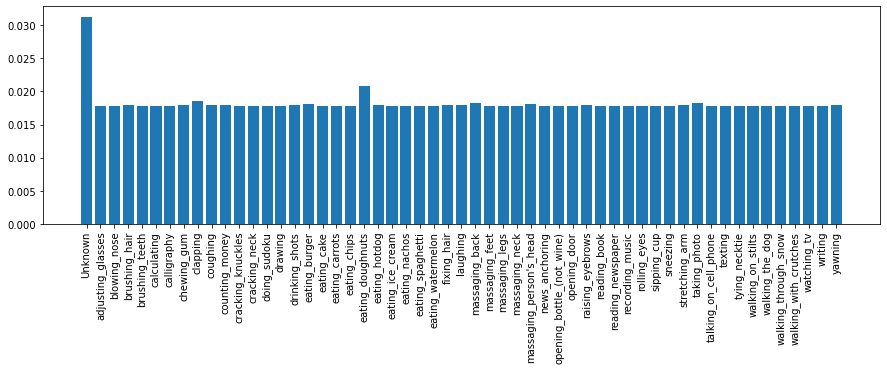

In [39]:
openmax(never_seen_path, model)

## Test - Kinetics - Wrong Prediction

In [40]:
# Data never seen

kinetics_paths = glob.glob("/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/train/others/building_cabinet/*.mp4")

kinetics_path = kinetics_paths[0]
kinetics_video = load_video(kinetics_path, image_size=(224,224))
media.show_video(kinetics_video, fps=5)

tensor(52, device='cuda:0') writing
tensor([2.6800e-03, 4.3765e-07, 1.6907e-05, 2.1721e-04, 1.4477e-03, 3.2145e-03,
        6.3033e-05, 1.4539e-06, 4.0922e-05, 9.1733e-05, 3.0925e-05, 1.0031e-05,
        4.1449e-03, 2.0005e-01, 3.8321e-07, 1.9380e-06, 2.4449e-05, 3.6291e-05,
        2.5586e-06, 3.7502e-06, 7.3663e-06, 2.7169e-06, 5.2611e-05, 2.7691e-05,
        1.5642e-07, 3.6466e-05, 2.4683e-05, 9.8112e-05, 3.1045e-06, 1.1917e-05,
        1.0896e-05, 7.2803e-07, 7.0737e-03, 1.2736e-04, 1.7109e-03, 7.8977e-05,
        1.5041e-03, 9.0676e-04, 4.7992e-03, 1.1340e-04, 1.9844e-07, 7.5535e-06,
        1.9379e-05, 7.8265e-05, 3.7360e-06, 8.3964e-05, 3.6161e-04, 7.7833e-05,
        5.4490e-05, 3.7220e-05, 1.7716e-03, 2.8708e-06, 7.6881e-01, 1.8807e-05],
       device='cuda:0')


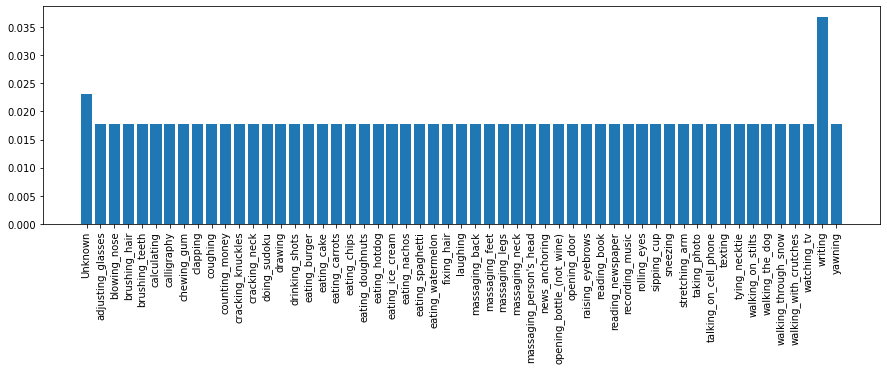

In [41]:
openmax(kinetics_path, model)

## Test - Kinetics - Correct Prediction

In [42]:
# Data never seen

kinetics_paths = glob.glob("/home/workspaces/mark/Video_Data/kinetics-datasets-downloader/downloader/dataset/val/normal/taking_photo/*.mp4")
kinetics_path = kinetics_paths[4]
kinetics_video = load_video(kinetics_path, image_size=(224,224))

# Visualize video
media.show_video(kinetics_video, fps=5)

tensor(43, device='cuda:0') taking_photo
tensor([5.3973e-04, 1.0545e-06, 7.2437e-07, 5.9735e-07, 4.6950e-04, 1.1768e-09,
        4.9361e-08, 6.8302e-08, 3.5728e-07, 8.1907e-06, 1.1722e-07, 8.1913e-08,
        2.0605e-06, 3.7929e-06, 3.9358e-06, 1.4926e-07, 1.9377e-07, 5.3607e-09,
        3.8024e-09, 1.6148e-06, 8.0882e-09, 2.9261e-07, 1.7899e-09, 1.9701e-09,
        1.4625e-09, 2.2207e-05, 2.1126e-08, 1.2389e-07, 9.1156e-08, 1.8178e-09,
        1.3217e-06, 1.7698e-06, 2.3401e-07, 1.0016e-04, 4.0891e-04, 2.9068e-07,
        1.4889e-07, 3.9103e-06, 5.4429e-04, 6.7973e-08, 3.3122e-06, 1.2915e-08,
        1.2536e-06, 9.6392e-01, 1.2523e-04, 3.3825e-02, 7.7603e-08, 3.0466e-07,
        3.8760e-08, 2.5963e-08, 1.1402e-08, 2.3658e-07, 4.6503e-06, 8.1896e-08],
       device='cuda:0')


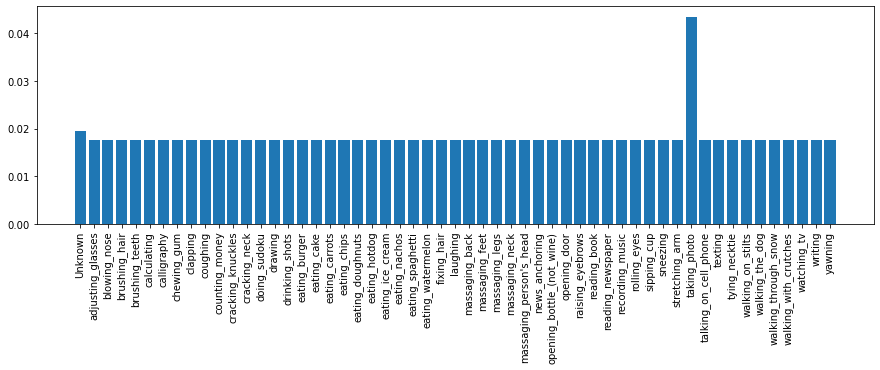

In [43]:
openmax(kinetics_path, model)